In [5]:
from shortfall.sim import Simulator, SimConfig
from shortfall.miners.repay_proportional import RepayProportionalShortfallMinerState
from shortfall.miners.burn import BurnShortfallMinerState
from shortfall.miners.repay_ratchet import RepayRatchetShortfallMinerState
from shortfall.network import *
from shortfall.strategy import *
from shortfall.consts import *

import dataclasses
import matplotlib.pyplot as plt
import pandas as pd

network = dataclasses.replace(MAINNET_APR_2023,
    token_lease_fee=0.20,
    reward_decay=REWARD_DECAY, # or try REWARD_DECAY + BASELINE_GROWTH
)
epochs = 3 * YEAR + 1
stats_interval = DAY

In [6]:
def show_miner_accounting_charts(df):
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(13.4, 4.8))

    # Balance sheet
    ax1.grid(axis='y', color='#EEE')
    ax1.plot(df['day'], df['net_equity'], label="Net equity")
    ax1.plot(df['day'], df['balance'], label="Balance")
    ax1.plot(df['day'], df['available'], '--', label="Available")
    ax1.plot(df['day'], -df['lease'], label="Lease")
    ax1.plot(df['day'], df['pledge_locked'], '--', label="Pledge locked")
    ax1.set_title("Miner equity")
    ax1.set_xlabel("Day")
    ax1.set_ylabel("FIL")
    ax1.legend()

    # PnL
    ax2.grid(axis='y', color='#EEE')
    ax2.plot(df['day'], df['reward_earned'], label="Rewards")
    ax2.plot(df['day'], -df['fee_burned'], label="Shortfall fee")
    ax2.plot(df['day'], -df['lease_fee_accrued'], label="Lease fee")
    ax2.set_title("Miner cash flow")
    ax2.set_xlabel("Day")
    ax2.legend()

    plt.show()

def compare_configurations(cfgs, title):
    statss = {label: pd.DataFrame(Simulator(cfg).run_all(epochs, stats_interval)) for (label, cfg) in cfgs.items()}

    plt.grid(axis='y', color='#EEE')
    for label, df in statss.items():
        plt.plot(df['day'], df['net_equity'], label=label)

    plt.plot()
    plt.title("Miner equity - " + title)
    plt.xlabel("Day")
    plt.ylabel("FIL")
    plt.legend()
    plt.show()

## Repay the shortfall

In [7]:
repay_miner_factory = RepayRatchetShortfallMinerState.factory(
    balance=0,
    max_repayment_term=3 * YEAR,
    max_fee_reward_fraction=0.25,
    reward_projection_decay=REWARD_DECAY + BASELINE_GROWTH
)
cfg = SimConfig(
    network=network,
    strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
    miner_factory=repay_miner_factory,
)
stats = Simulator(cfg).run_all(epochs, stats_interval)
repay_shortfall_df = pd.DataFrame(data=stats)
repay_shortfall_df

,day,power_eib,balance,lease,pledge_locked,available,net_equity,reward_earned,fee_burned,lease_fee_accrued,pledge_required,shortfall,shortfall_pct
0,1,0.00021862629,1000.0,1000.547945,1000.0,0.0,-0.547945,0.0,0.0,0.547945,1595.6995,595.69946,37.329998
1,2,0.00021862629,1002.03613,1001.0962,1002.03613,0.0,0.9399414,2.7148597,0.67871493,1.0961907,1595.6995,593.6633,37.2
2,3,0.00021862629,1004.07166,1001.6429,1004.07166,0.0,2.428772,5.42886,1.355324,1.6447356,1595.6995,591.6278,37.079998
3,4,0.00021862629,1006.1065,1002.18774,1006.1065,0.0,3.9187622,8.142002,2.0296133,2.1935787,1595.6995,589.59296,36.95
4,5,0.00021862629,1008.14075,1002.73083,1008.14075,0.0,5.409912,10.854285,2.7015834,2.7427194,1595.6995,587.5587,36.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,1092,0.00021862629,2057.939,0.0,1595.6995,462.2395,2057.939,2505.0352,102.85308,344.24414,1595.6995,0.0,0.0
1092,1093,0.00021862629,2059.861,0.0,1595.6995,464.16162,2059.861,2506.9573,102.85308,344.24414,1595.6995,0.0,0.0
1093,1094,0.00021862629,2061.7827,0.0,1595.6995,466.08325,2061.7827,2508.879,102.85308,344.24414,1595.6995,0.0,0.0
1094,1095,0.00021862629,2063.7036,0.0,1595.6995,468.00415,2063.7036,2510.7998,102.85308,344.24414,1595.6995,0.0,0.0


<Figure size 640x480 with 0 Axes>

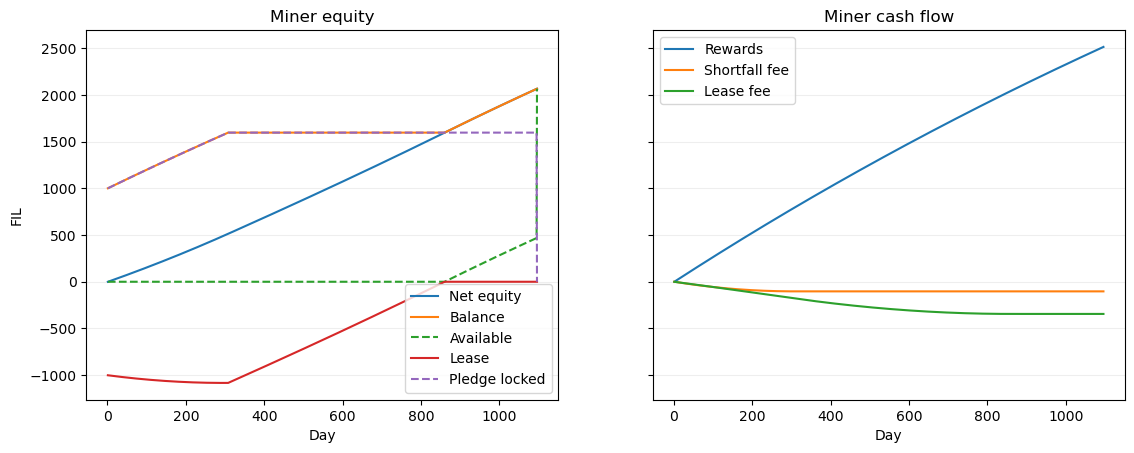

In [8]:
show_miner_accounting_charts(repay_shortfall_df)

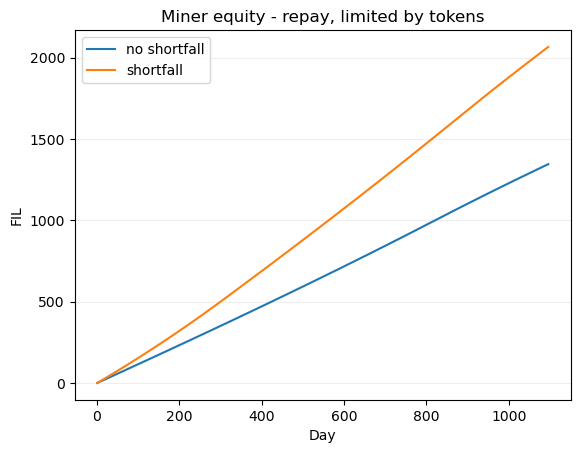

In [9]:
# Configurations limited by token availability.
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, False),
        miner_factory=repay_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
        miner_factory=repay_miner_factory,
    )
}, 'repay, limited by tokens')

In [10]:
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100*TIBIBYTE, 3*YEAR, False),
        miner_factory=repay_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100*TIBIBYTE, 3*YEAR, True),
        miner_factory=repay_miner_factory,
    )
}, 'repay, limited by power')

OverflowError: Python int 109951162777600 too large to convert to int32

## Burn the shortfall

In [ ]:
burn_miner_factory = BurnShortfallMinerState.factory(balance=0)
cfg = SimConfig(
    network=network,
    strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
    miner_factory=burn_miner_factory,
)
stats = Simulator(cfg).run_all(epochs, stats_interval)
burn_shortfall_df = pd.DataFrame(data=stats)
burn_shortfall_df


,day,epoch,power,balance,lease,pledge_locked,available,net_equity,reward_earned,fee_burned,lease_fee_accrued,fee_pending
0,0,1,316453190369280,1000.0000,1000.0002,1000.0,0.0000,-0.0002,0.0000,0.0000,0.0002,999.9659
1,1,2881,316453190369280,1000.0000,999.6947,1000.0,0.0000,0.3053,3.4090,2.5556,0.5481,997.4103
2,2,5761,316453190369280,1000.0000,999.3871,1000.0,0.0000,0.6129,6.8169,5.1082,1.0957,994.8577
3,3,8641,316453190369280,1000.0000,999.0774,1000.0,0.0000,0.9226,10.2237,7.6578,1.6433,992.3081
4,4,11521,316453190369280,1000.0000,998.7657,1000.0,0.0000,1.2343,13.6294,10.2045,2.1906,989.7614
...,...,...,...,...,...,...,...,...,...,...,...,...
1091,1091,3142081,316453190369280,1902.7765,0.0000,1000.0,902.7765,1902.7765,3145.5014,990.9618,251.7631,9.0041
1092,1092,3144961,316453190369280,1905.1472,0.0000,1000.0,905.1472,1905.1472,3147.9150,991.0046,251.7631,8.9613
1093,1093,3147841,316453190369280,1907.5175,0.0000,1000.0,907.5175,1907.5175,3150.3278,991.0472,251.7631,8.9187
1094,1094,3150721,316453190369280,1909.8871,0.0000,1000.0,909.8871,1909.8871,3152.7398,991.0895,251.7631,8.8764


<Figure size 640x480 with 0 Axes>

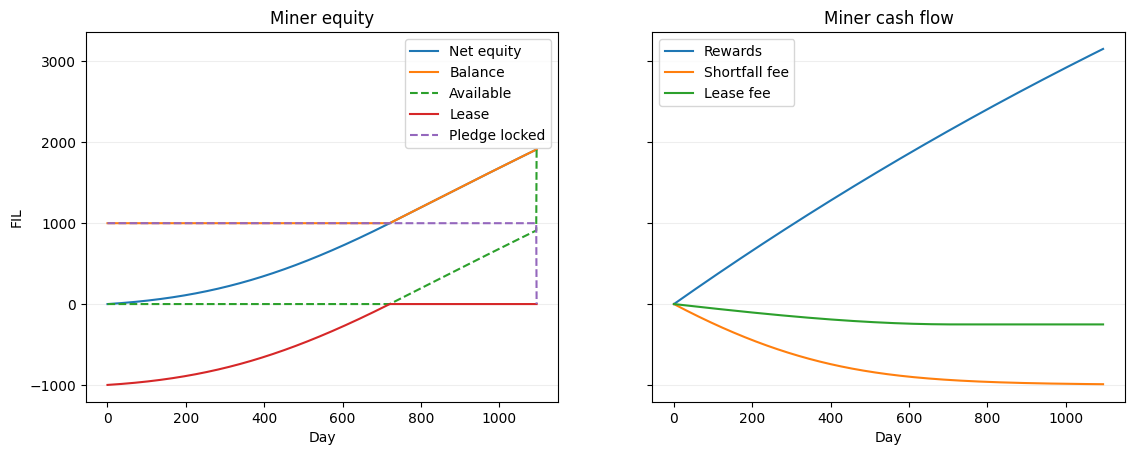

In [ ]:
show_miner_accounting_charts(burn_shortfall_df)

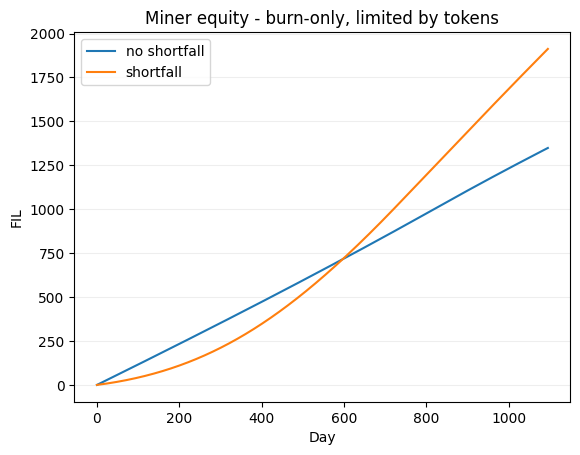

In [ ]:
# Configurations limited by token availability.
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, False),
        miner_factory=burn_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
        miner_factory=burn_miner_factory,
    )
}, 'burn-only, limited by tokens')


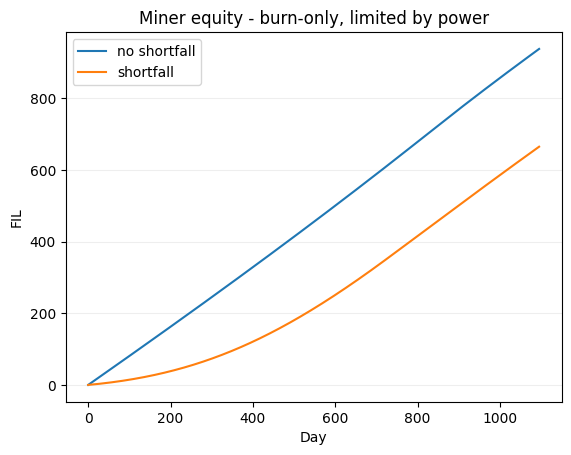

In [ ]:
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100 * TIBIBYTE, 3 * YEAR, False),
        miner_factory=burn_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100 * TIBIBYTE, 3 * YEAR, True),
        miner_factory=burn_miner_factory,
    )
}, 'burn-only, limited by power')
